# The Variational Autoencoder

In this notebook we are interested in the problem of inference in a probabilistic model that contains both observed and latent variables, which can be represented as the following graphical model:

<div style="text-align:center;">
<img src="graph-latent.png">
</div>

For this model the joint probability distribution factorizes as

$$
p(\mathbf{x}, \mathbf{z}\vert\boldsymbol{\theta}) = p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta})p(\mathbf{z}\vert\boldsymbol{\theta})
$$

For any distribution $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$, we can write the marginal log-likelihood as the sum of two terms: the evidence lower bound $\mathcal{L}(q, \boldsymbol{\theta},\boldsymbol{\phi})$ and the KL divergence between $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$ and the posterior $p(\mathbf{z}\vert\mathbf{x},\boldsymbol{\theta})$:

$$
\log p(\mathbf{x}\vert\boldsymbol{\theta}) = \mathcal{L}(q, \boldsymbol{\theta}, \boldsymbol{\phi}) + \text{KL}(q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})\Vert p(\mathbf{z\vert\mathbf{x}, \boldsymbol{\theta}}))
$$

Our goal is to find the values of $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ that maximize the marginal log-likelihood. In *variational inference*, we propose $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$ as an approximation to the posterior, so that the KL divergence is minimized. The KL divergence is minimized when we maximize the lower bound, defined as

$$
\begin{align}
\mathcal{L}(q, \boldsymbol{\theta}, \boldsymbol{\phi}) &= \mathbb{E}_q[\log p(\mathbf{x},\mathbf{z}\vert\boldsymbol{\theta}) - \log q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})]\\
&=
\mathbb{E}_q[\log p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta})] - \text{KL}(q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})\Vert p(\mathbf{z}\vert\boldsymbol{\theta}))
\end{align}
$$

We can think of $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$ as taking the variable $\mathbf{x}$ and producing a distribution over the latent variable $\mathbf{z}$. For this reason $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$ is also known as the **encoder**: the latent variable $\mathbf{z}$ acts as a code for the observation $\mathbf{x}$. The parameters $\boldsymbol{\phi}$ are known as the **variational parameters**, because they correspond to the distribution $q$ that we want to use as an approximation to the true posterior.

Similarly, we can see that our model for $p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta})$ does the opposite: given a latent representation, a distribution over the observation is produced. Therefore $p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta})$ is also known as the **decoder**, which takes the code $\mathbf{z}$ and reconstructs the observation $\mathbf{x}$. The parameters $\boldsymbol{\theta}$ are known as the **generative parameters**.

To maximize the lower bound, we can obtain its gradient with respect to the parameters and then update them in that direction:

$$
\nabla_{\boldsymbol{\theta},\boldsymbol{\phi}} \mathcal{L}(q, \boldsymbol{\theta}, \boldsymbol{\phi}) = \nabla_{\boldsymbol{\theta},\boldsymbol{\phi}}
\left[
\mathbb{E}_q[\log p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta})] - \text{KL}(q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})\Vert p(\mathbf{z}\vert\boldsymbol{\theta}))
\right]
$$

For some cases, the KL divergence can be calculated analytically, as well as its gradient with respect to both the generative and variational parameters. The expectation term can be approximated with a *Monte Carlo estimate*, by taking samples and averaging the result. However, how do we calculate the derivative with respect to $\boldsymbol{\phi}$ of a sampling operation from a distribution whose parameter is $\boldsymbol{\phi}$ itself?

## The reparameterization trick

Instead of using $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$ to obtain samples of $\mathbf{z}$, we will introduce an auxiliary random variable $\boldsymbol{\epsilon}$ with a corresponding, known distribution $p(\boldsymbol{\epsilon})$. We obtain a sample $\boldsymbol{\epsilon}$ from this distribution, and then we let $\mathbf{z}$ be a deterministic, differentiable function of it:

$$
\mathbf{z} = g(\mathbf{x},\boldsymbol{\epsilon},\boldsymbol{\phi})
$$

Given an appropriate choice of $p(\boldsymbol{\epsilon})$ and $g$, $\mathbf{z}$ would be as if we had sampled from $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$, which is what we wanted. The difference now is that the sample $\mathbf{z}$ was obtained from a differentiable function, and now we can obtain the gradient with respect to $\boldsymbol{\phi}$! We can take $L$ samples to obtain the Monte Carlo estimate of the expectation and then differentiate:

$$
\nabla_{\boldsymbol{\theta},\boldsymbol{\phi}} \mathcal{L}(q, \boldsymbol{\theta}, \boldsymbol{\phi}) \approx \nabla_{\boldsymbol{\theta},\boldsymbol{\phi}}\frac{1}{L}\sum_{i=1}^L \log p(\mathbf{x}\vert\mathbf{z}^{(i)},\boldsymbol{\theta})
$$

with $\mathbf{z}^{(i)}$ is obtained for each sample of $\boldsymbol{\epsilon}$.

## The algorithm

We now have an algorithm to optimize the lower bound, known as **Autoencoding Variational Bayes** [1]:

- Take an observation $\mathbf{x}$
- Take $L$ samples of $\boldsymbol{\epsilon}\sim p(\boldsymbol{\epsilon})$ and let $\mathbf{z}^{(i)}=g(\mathbf{x},\boldsymbol{\epsilon}^{(i)},\boldsymbol{\phi})$
- Calculate $\mathbf{g} = \nabla_{\boldsymbol{\theta},\boldsymbol{\phi}}\lbrace\frac{1}{L}\sum_{i=1}^L \log p(\mathbf{x}\vert\mathbf{z}^{(i)},\boldsymbol{\theta}) - \text{KL}(q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})\Vert p(\mathbf{z}\vert\boldsymbol{\theta}))\rbrace$
- Update $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ using $\mathbf{g}$ and an optimizer like Stochastic Gradient Descent or Adam.

## A practical example

As in the EM example, we will now define a generative model for the MNIST digits dataset. This time, however, we will assume the latent variables to be continuous instead of discrete, so that $\mathbf{z}\in\mathbb{R}^K$ where $K$ is a hyperparameter that indicates the dimension of the latent space. We choose the prior distribution as a Gaussian with zero mean and unit covariance,

$$
p(\mathbf{z}) = \mathcal{N}(\mathbf{z}\vert\mathbf{0}, \mathbf{I})
$$

Given an observation $\mathbf{x}$, the approximation of the posterior $p(\mathbf{z}\vert\mathbf{x},\boldsymbol{\theta})$ (the encoder) will be a Gaussian distribution with diagonal covariance:

$$
q(\mathbf{z}\vert\mathbf{x}, \boldsymbol{\phi}) = \mathcal{N}(\mathbf{z}\vert\boldsymbol{\mu}_e,\text{diag}(\boldsymbol{\sigma}_e))
$$

with

$$
\begin{align}
\boldsymbol{\mu}_e &= f_{\phi_\mu}(\mathbf{x})\\
\log(\boldsymbol{\sigma}_e^2) &= f_{\phi_\sigma}(\mathbf{x})
\end{align}
$$

where $e$ in the subscripts refer to the *encoder*, and $f_{\phi_\mu}$ and $f_{\phi_\sigma}$ are neural networks with weights $\boldsymbol{\phi}_\mu$ and $\boldsymbol{\phi}_\sigma$, respectively. These parameters form the parameters of the encoder: $\boldsymbol{\phi} = \lbrace\boldsymbol{\phi}_\mu,\boldsymbol{\phi}_\sigma\rbrace$. The reparameterization trick for this case is

$$
\begin{align}
\boldsymbol{\epsilon}&\sim\mathcal{N}(\mathbf{0}, \mathbf{I})\\
\mathbf{z} &= \boldsymbol{\mu}_e + \boldsymbol{\sigma}_e\odot\boldsymbol{\epsilon}
\end{align}
$$

where $\odot$ denotes element-wise multiplication.

For the prior and approximate posterior that we have defined, the KL divergence is

$$
\text{KL}(q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})\Vert p(\mathbf{z}\vert\boldsymbol{\theta})) = \frac{1}{2}\sum_{i=1}^K(\sigma_{ei}^2 + \mu_{ei}^2 - \log(\sigma_{ei}^2) - 1)
$$

Since the pixels in the images are binary, we model an observation $\mathbf{x}\in\mathbb{R}^D$, given the latent variable $\mathbf{z}$, as a multivariate Bernoulli random variable with mean $\boldsymbol{\mu}_d$. This corresponds to the *decoder*:

$$
p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta}) = \prod_{i=1}^D \mu_{di}^{x_i}(1-\mu_{di})^{(1-x_i)}
$$

with

$$
\boldsymbol{\mu}_d = f_\theta(\mathbf{z})
$$

where $f_\theta$ is a neural network with weights $\boldsymbol{\theta}$. Note that since the output of the decoder models a distribution over a multivariate Bernoulli, we must ensure that its values lie within 0 and 1. We do this with a sigmoid layer at the output.

Given this definition of the decoder, we have

$$
\log p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta}) = \sum_{i=1}^D x_i\log\mu_{di} + (1-x_i)\log(1-\mu_{di})
$$

which is the negative binary cross-entropy loss. We now have all the ingredients to implement and train the autoencoder, for which we will use PyTorch.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal

class BernoulliVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_units, dec_units):
        super(BernoulliVAE, self).__init__()
        # Encoder parameters
        self.linear_enc = nn.Linear(input_dim, enc_units)
        self.enc_mu = nn.Linear(enc_units, latent_dim)
        self.enc_logvar = nn.Linear(enc_units, latent_dim)

        # Distribution to sample for the reparameterization trick
        self.normal_dist = MultivariateNormal(torch.zeros(latent_dim),
                                              torch.eye(latent_dim))

        # Decoder parameters
        self.linear_dec = nn.Linear(latent_dim, dec_units)
        self.dec_mu = nn.Linear(dec_units, input_dim)

        # Reconstruction loss: binary cross-entropy
        self.criterion = nn.BCELoss(reduction='sum')

    def encode(self, x):
        # Obtain the parameters of the latent variable distribution
        h = torch.relu(self.linear_enc(x))
        mu_e = self.enc_mu(h)
        logvar_e = self.enc_logvar(h)

        # Get a latent variable sample with the reparameterization trick
        epsilon = self.normal_dist.sample((x.shape[0],))
        z = mu_e + torch.sqrt(torch.exp(logvar_e)) * epsilon

        return z, mu_e, logvar_e

    def decode(self, z):
        # Obtain the parameters of the observation distribution
        h = torch.relu(self.linear_dec(z))
        mu_d = torch.sigmoid(self.dec_mu(h))

        return mu_d

    def forward(self, x):
        """ Calculate the negative lower bound for the given input """
        z, mu_e, logvar_e = self.encode(x)
        mu_d = self.decode(z)
        neg_cross_entropy = self.criterion(mu_d, x)
        kl_div = -0.5* (1 + logvar_e - mu_e**2 - torch.exp(logvar_e)).sum(dim=-1)
        kl_div = kl_div.mean()

        # Since the optimizer minimizes, we return the negative
        # of the lower bound that we need to maximize
        return neg_cross_entropy + kl_div

We can now load the data, create a model and train it. We will choose 10 for the dimension of the latent space, and 300 units in the hidden layer for both the encoder and the decoder.

In [6]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

input_dim = 28 * 28
batch_size = 128
epochs = 5

dataset = datasets.MNIST('data/', transform=transforms.ToTensor(), download=True)
loader = DataLoader(dataset, batch_size, shuffle=True)
model = BernoulliVAE(input_dim, latent_dim=10, enc_units=200, dec_units=200)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}')
    avg_loss = 0
    for i, (data, _) in enumerate(loader):
        model.zero_grad()
        # Reshape data so each image is an array with 784 elements
        data = data.view(-1, input_dim)
        
        loss = model(data)
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()/len(dataset)
        
        if i % 100 == 0:
            # Print average loss per sample in batch
            batch_loss = loss.item()/len(data)
            print(f'\r[{i:d}/{len(loader):d}] batch loss: {batch_loss:.3f}',
                  end='', flush=True)
        
    print(f'\nAverage loss: {avg_loss:.6f}'.format(avg_loss))        

Epoch 1
[400/469] batch loss: 99.3172
Average loss: 115.720994
Epoch 2
[400/469] batch loss: 94.667
Average loss: 94.364775
Epoch 3
[400/469] batch loss: 89.494
Average loss: 91.969348
Epoch 4
[400/469] batch loss: 93.098
Average loss: 90.915360
Epoch 5
[400/469] batch loss: 90.385
Average loss: 90.130152


Let's now use the autoencoder to take observations and reconstruct them from their latent representation.

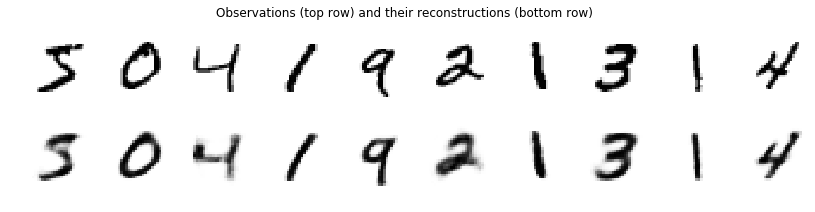

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 10
fig = plt.figure(figsize=(14, 3))
fig.suptitle('Observations (top row) and their reconstructions (bottom row)')
for i in range(n_samples):
    # Take a sample and view as mini-batch of size 1
    x = dataset[i][0].view(-1, input_dim)
    # Encode the observation
    z, mu_e, logvar_e = model.encode(x)
    # Get reconstruction
    x_d = model.decode(z)
    
    plt.subplot(2, n_samples, i + 1)
    plt.imshow(x.view(28, 28).data.numpy(), cmap='binary')
    plt.axis('off')
    plt.subplot(2, n_samples, i + 1 + n_samples)
    plt.imshow(x_d.view(28, 28).data.numpy(), cmap='binary')
    plt.axis('off')

We can see that the model effectively creates a representation of the latent variable $\mathbf{z}$ that contains enough information to reconstruct a digit very similar to the original observation.

The encoded representation acts as a low dimensional representation of the observation. The digit images have 784 pixels in total, with each pixel having values between 0 and 1. Therefore, the images lie in a certain region of $\mathbb{R}^{784}$. Their encoded representation, on the other hand, lies in a region of $\mathbb{R}^{10}$, which hopefully encodes a compact and meaningful representation of a digit. We can observed this with visualization techniques, such as t-SNE:

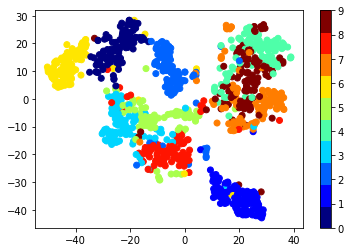

In [15]:
from sklearn.manifold import TSNE
import numpy as np

# Select 1000 random samples
sample_idx = np.random.randint(0, len(dataset), size=1000)
X = torch.cat([dataset[i][0].view(-1, input_dim) for i in sample_idx])
labels = dataset.train_labels[sample_idx].data.numpy()

Z, _, _ = model.encode(X)
Z_vis = TSNE(n_components=2).fit_transform(Z.data.numpy())

plt.scatter(Z_vis[:, 0], Z_vis[:, 1], c=labels, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar();

As we expected, numbers of the same class cluster together in some regions of the space. This is possible thanks to the latent space discovered by the autoencoder. 

The variational autoencoder is a powerful model for unsupervised learning that can be used in many applications like visualization, machine learning models that work on top of the compact latent representation, and inference in models with latent variables as the one we have explored. A particular example of this last application is reflected in the Bayesian Skip-gram [2], which I plan to explore in the near future.

### References

[1] Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).

[2] Bražinskas, Arthur, Serhii Havrylov, and Ivan Titov. "Embedding Words as Distributions with a Bayesian Skip-gram Model." arXiv preprint arXiv:1711.11027 (2017).

### Some final notes

1. In the Expectation Maximization algorithm, we get around the problem of inference in models with latent variables by calculating the posterior and simply setting $q(\mathbf{z}\vert\boldsymbol{\phi}) = p(\mathbf{z}\vert\mathbf{x},\boldsymbol{\theta})$, which effectively makes the KL divergence equal to zero. However, for some models calculating the posterior is not possible. Furthermore, the EM algorithm calculates updates using the complete dataset, which might not scale up well when we have millions of data points. The VAE addresses these issues by proposing an approximation to the posterior, and optimizing the parameters of the approximation with stochastic gradient descent.

2. Recall the expression for the evidence lower bound:
    $$
    \begin{align}
    \mathcal{L}(q, \boldsymbol{\theta}, \boldsymbol{\phi}) &= \mathbb{E}_q[\log p(\mathbf{x},\mathbf{z}\vert\boldsymbol{\theta}) - \log q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})]\\
    &=
    \mathbb{E}_q[\log p(\mathbf{x}\vert\mathbf{z},\boldsymbol{\theta})] - \text{KL}(q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})\Vert p(\mathbf{z}\vert\boldsymbol{\theta}))
    \end{align}
    $$

    This last formulation reveals what optimizing the lower bound does. Maximizing the first term finds parameters that given the latent variable $\mathbf{z}$, assign high probability to the observation $\mathbf{x}$. We can think of this as a negative reconstruction error, that is, a reconstruction from the latent variable $\mathbf{z}$ to the observation $\mathbf{x}$. Maximizing the second term (including the minus sign) minimizes the KL divergence between $q(\mathbf{z}\vert\mathbf{x},\boldsymbol{\phi})$ and the prior $p(\mathbf{z}\vert\boldsymbol{\theta})$, thus acting as a regularizer that enforces a prior structure that we have specified. Briefly stated, we then have

    $$
    \text{lower bound} = -\text{reconstruction error} - \text{regularization penalty}
    $$

    Therefore, values of $\boldsymbol{\theta}$ and $\boldsymbol{\phi}$ that maximize the lower bound will produce a low reconstruction error and a model that takes into account prior information.